# Statistical Analysis of GA Hyperparameter Experiments

This notebook analyzes results from multiple GA runs with different hyperparameters to identify which settings work best.

In [1]:
# ============================================================
# CONFIGURATION - Set these parameters
# ============================================================

# Which runner configuration to analyze
runner_name = 'Baseline'  # e.g., 'Baseline', 'PopSize+Generations', 'CostWeights', etc.

# Was fast_mode used?
fast_mode = False  # Set to True if analyzing fast_mode results

# Results directory
results_dir = '../../results/many_ga/abbr/'

# Generations to analyze
generations_to_analyze = [50, 100, 150, 199] if not fast_mode else [2,3,4,5]

In [2]:
import sys
sys.path.append('../core')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import dill
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

def compute_pvalue(df, modifier, outcome_var='cost_final'):
    """
    Compute p-value for association between modifier and outcome using linear regression.
    
    This uses ordinary least squares regression and returns the p-value for the slope coefficient.
    For binary variables, this is equivalent to a t-test.
    
    Returns: (p_value, test_name)
    """
    df_clean = df[[modifier, outcome_var]].dropna()
    
    # Need at least 3 samples for meaningful statistics
    if len(df_clean) < 3:
        return np.nan, 'insufficient_data'
    
    # Check if there's any variation in the modifier
    if df_clean[modifier].nunique() <= 1:
        return np.nan, 'no_variation'
    
    try:
        # Convert to numeric if boolean
        X = pd.to_numeric(df_clean[modifier], errors='coerce')
        y = df_clean[outcome_var]
        
        # Remove any NaN that resulted from conversion
        mask = ~(X.isna() | y.isna())
        X = X[mask]
        y = y[mask]
        
        if len(X) < 3:
            return np.nan, 'insufficient_data'
        
        # Perform linear regression using scipy
        slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
        
        return p_value, 'LinReg'
        
    except Exception as e:
        return np.nan, 'error'

def format_pvalue(p_val):
    """Format p-value for display"""
    if np.isnan(p_val):
        return 'p=N/A'
    elif p_val < 0.001:
        return 'p<0.001***'
    elif p_val < 0.01:
        return f'p={p_val:.3f}**'
    elif p_val < 0.05:
        return f'p={p_val:.3f}*'
    else:
        return f'p={p_val:.3f}'

def plot_modifier_vs_outcome(ax, df, modifier, outcome_var, show_pval=True):
    """
    Plot modifier vs outcome variable (cost or runtime).
    Uses box plot for binary variables, scatter plot otherwise.
    
    Parameters:
    -----------
    ax : matplotlib axis
    df : DataFrame
    modifier : str - column name of modifier/hyperparameter
    outcome_var : str - column name of outcome (e.g., 'cost_final', 'runtime')
    show_pval : bool - whether to show p-value in title
    
    Returns:
    --------
    p_val : float - p-value for the association
    """
    is_numeric = pd.api.types.is_numeric_dtype(df[modifier])
    is_boolean = df[modifier].dtype == bool or set(df[modifier].unique()).issubset({True, False, np.nan})
    n_unique = df[modifier].nunique()
    
    df_plot = df[[modifier, outcome_var]].dropna()
    
    if len(df_plot) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        return np.nan
    
    # Compute p-value using linear regression
    p_val, test_name = compute_pvalue(df, modifier, outcome_var)
    
    # Use box plot only for binary variables
    if n_unique == 2:
        sns.boxplot(data=df_plot, x=modifier, y=outcome_var, ax=ax)
        ax.set_xlabel(modifier, fontsize=9)
    else:
        # Use scatter plot for everything else
        ax.scatter(df_plot[modifier], df_plot[outcome_var], alpha=0.6, s=50)
        
        # Add trend line if numeric with >2 unique values
        if is_numeric and len(df_plot) > 1 and n_unique > 2:
            z = np.polyfit(df_plot[modifier], df_plot[outcome_var], 1)
            p = np.poly1d(z)
            x_line = np.linspace(df_plot[modifier].min(), df_plot[modifier].max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        
        ax.set_xlabel(modifier, fontsize=9)
    
    ax.set_ylabel(outcome_var.replace('_', ' ').title(), fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add p-value to title if requested
    if show_pval:
        title = f'{format_pvalue(p_val)}'
        ax.set_title(title, fontsize=9)
    
    return p_val

print("Imports complete")

Imports complete


## Load Results

In [3]:
# Find all result files matching the runner name
pattern = f"{results_dir}/{runner_name}_*_*.pkl"
result_files = sorted(glob.glob(pattern))

print(f"Found {len(result_files)} result files for '{runner_name}'")
print(f"Pattern: {pattern}")

if len(result_files) == 0:
    print("\nNo files found! Available files:")
    all_files = glob.glob(f"{results_dir}/*.pkl")
    for f in all_files[:10]:
        print(f"  {Path(f).name}")
    if len(all_files) > 10:
        print(f"  ... and {len(all_files)-10} more")

Found 22 result files for 'Baseline'
Pattern: ../../results/many_ga/abbr//Baseline_*_*.pkl


In [4]:
# Load all results and extract data
data_records = []
skipped_fast = 0
skipped_slow = 0

for filepath in result_files:
    try:
        with open(filepath, 'rb') as f:
            r = dill.load(f)
        
        # Skip if exception occurred
        if r.exception is not None:
            print(f"Skipping {Path(filepath).name} - exception occurred")
            continue
        
        # Skip if no results
        if r.best_costs is None:
            print(f"Skipping {Path(filepath).name} - no best_costs")
            continue

        # Filter by fast_mode based on number of generations
        n_gens = r.best_costs.shape[0]
        is_fast_mode_result = n_gens < 100  # Fast mode typically has fewer generations
        if fast_mode and not is_fast_mode_result:
            skipped_slow += 1
            continue  # Skip slow mode results when analyzing fast mode
        if not fast_mode and is_fast_mode_result:
            skipped_fast += 1
            continue  # Skip fast mode results when analyzing slow mode

        # Extract basic info
        record = {
            'seed': r.seed,
            'runtime': r.runtime_seconds if hasattr(r, 'runtime_seconds') else np.nan,
            'filename': Path(filepath).name,
            'n_generations': n_gens
        }
        
        # Extract modifier values (hyperparameters)
        for key, value in r.modifier_values.items():
            if key != 'seed':
                record[key] = value
        
        # Extract costs at different generations
        for gen in generations_to_analyze:
            if gen < n_gens:
                # Average cost across all N_trees values
                record[f'cost_gen_{gen}'] = np.mean(r.best_costs[gen, :])
                # Also store per-tree costs
                for i_tree in range(r.best_costs.shape[1]):
                    n_trees = r.base_ga.N_trees_to_do[i_tree] if hasattr(r, 'base_ga') else i_tree
                    record[f'cost_gen_{gen}_trees_{n_trees}'] = r.best_costs[gen, i_tree]
        
        # Final cost
        record['cost_final'] = np.mean(r.best_costs[-1, :])
        record['cost_final_std'] = np.std(r.best_costs[-1, :])
        
        data_records.append(record)
        
    except Exception as e:
        print(f"Error loading {Path(filepath).name}: {e}")

# Create DataFrame
df = pd.DataFrame(data_records)

print(f"\nSuccessfully loaded {len(df)} runs")
if skipped_fast > 0:
    print(f"Skipped {skipped_fast} fast-mode runs (analyzing slow mode)")
if skipped_slow > 0:
    print(f"Skipped {skipped_slow} slow-mode runs (analyzing fast mode)")
print(f"Columns: {list(df.columns)}")
print(f"\nDataFrame shape: {df.shape}")
if len(df) > 0:
    print(f"Generation range: {df['n_generations'].min()}-{df['n_generations'].max()}")
df.head()

vast
stop final relax at some point

Successfully loaded 21 runs
Skipped 1 fast-mode runs (analyzing slow mode)
Columns: ['seed', 'runtime', 'filename', 'n_generations', 'scale_population', 'genetic_diversity', 'no_jiggle', 'bfgs_for_rough', 'scale_rough_iterations', 'scale_fine_iterations', 'rough_steps', 'fine_steps', 'disable_MoveRandomTree', 'disable_JiggleTreeSmall', 'disable_JiggleTreeBig', 'disable_JiggleClusterSmall', 'disable_JiggleClusterBig', 'disable_Translate', 'disable_Twist', 'disable_Crossover', 'cost_gen_50', 'cost_gen_50_trees_40', 'cost_gen_100', 'cost_gen_100_trees_40', 'cost_gen_150', 'cost_gen_150_trees_40', 'cost_gen_199', 'cost_gen_199_trees_40', 'cost_final', 'cost_final_std']

DataFrame shape: (21, 30)
Generation range: 200-200


,seed,runtime,filename,n_generations,scale_population,genetic_diversity,no_jiggle,bfgs_for_rough,scale_rough_iterations,scale_fine_iterations,...,cost_gen_50,cost_gen_50_trees_40,cost_gen_100,cost_gen_100_trees_40,cost_gen_150,cost_gen_150_trees_40,cost_gen_199,cost_gen_199_trees_40,cost_final,cost_final_std
0,0,621.869419,Baseline_0_649cbc14_a.pkl,200,6.732655,False,True,True,0.114875,0.831943,...,0.147887,0.147887,0.147882,0.147882,0.147097,0.147097,0.146889,0.146889,0.146889,0.0
1,100,2756.345239,Baseline_100_649cbc14_a.pkl,200,8.514835,True,False,True,0.138656,0.976289,...,0.144789,0.144789,0.144789,0.144789,0.144789,0.144789,0.144789,0.144789,0.144789,0.0
2,101,2295.897719,Baseline_101_649cbc14_a.pkl,200,9.491793,False,True,True,0.632150,0.364896,...,0.147309,0.147309,0.147309,0.147309,0.147309,0.147309,0.147309,0.147309,0.147309,0.0
3,102,1007.043750,Baseline_102_649cbc14_a.pkl,200,2.439920,False,False,True,0.367534,0.716410,...,0.146602,0.146602,0.146601,0.146601,0.146601,0.146601,0.146601,0.146601,0.146601,0.0
4,103,881.481148,Baseline_103_649cbc14_a.pkl,200,3.814149,True,True,False,0.874161,0.871788,...,0.147751,0.147751,0.146963,0.146963,0.144119,0.144119,0.143797,0.143797,0.143797,0.0


## Summary Statistics

In [5]:
if len(df) > 0:
    print("=" * 70)
    print("OVERALL SUMMARY")
    print("=" * 70)
    print(f"\nTotal runs: {len(df)}")
    print(f"\nRuntime statistics:")
    if 'runtime' in df.columns and not df['runtime'].isna().all():
        print(f"  Mean: {df['runtime'].mean():.1f}s")
        print(f"  Median: {df['runtime'].median():.1f}s")
        print(f"  Min: {df['runtime'].min():.1f}s")
        print(f"  Max: {df['runtime'].max():.1f}s")
    else:
        print("  No runtime data available")
    
    print(f"\nFinal cost statistics:")
    print(f"  Mean: {df['cost_final'].mean():.6f}")
    print(f"  Median: {df['cost_final'].median():.6f}")
    print(f"  Min: {df['cost_final'].min():.6f}")
    print(f"  Max: {df['cost_final'].max():.6f}")
    print(f"  Std: {df['cost_final'].std():.6f}")
    
    print(f"\nBest 5 runs (by final cost):")
    best_runs = df.nsmallest(5, 'cost_final')
    for idx, row in best_runs.iterrows():
        print(f"  Seed {row['seed']:3d}: cost={row['cost_final']:.6f}, runtime={row.get('runtime', np.nan):.1f}s")
    
    print(f"\nWorst 5 runs (by final cost):")
    worst_runs = df.nlargest(5, 'cost_final')
    for idx, row in worst_runs.iterrows():
        print(f"  Seed {row['seed']:3d}: cost={row['cost_final']:.6f}, runtime={row.get('runtime', np.nan):.1f}s")
    
    # Identify modifier columns (hyperparameters)
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std'] and 
                     not col.startswith('cost_gen_')]
    
    if len(modifier_cols) > 0:
        print(f"\nHyperparameters varied: {', '.join(modifier_cols)}")
else:
    print("No data loaded!")

OVERALL SUMMARY

Total runs: 21

Runtime statistics:
  Mean: 1180.8s
  Median: 960.3s
  Min: 432.3s
  Max: 2756.3s

Final cost statistics:
  Mean: 0.146026
  Median: 0.145613
  Min: 0.143797
  Max: 0.148593
  Std: 0.001537

Best 5 runs (by final cost):
  Seed 103: cost=0.143797, runtime=881.5s
  Seed   2: cost=0.143808, runtime=684.1s
  Seed  10: cost=0.144494, runtime=2091.1s
  Seed   4: cost=0.144579, runtime=1811.0s
  Seed   9: cost=0.144666, runtime=1875.5s

Worst 5 runs (by final cost):
  Seed  12: cost=0.148593, runtime=442.9s
  Seed   6: cost=0.148548, runtime=651.5s
  Seed   1: cost=0.147989, runtime=722.5s
  Seed  16: cost=0.147692, runtime=750.4s
  Seed   8: cost=0.147417, runtime=457.0s

Hyperparameters varied: n_generations, scale_population, genetic_diversity, no_jiggle, bfgs_for_rough, scale_rough_iterations, scale_fine_iterations, rough_steps, fine_steps, disable_MoveRandomTree, disable_JiggleTreeSmall, disable_JiggleTreeBig, disable_JiggleClusterSmall, disable_JiggleClu

## Convergence Analysis

Plot costs at different generations to see convergence patterns.

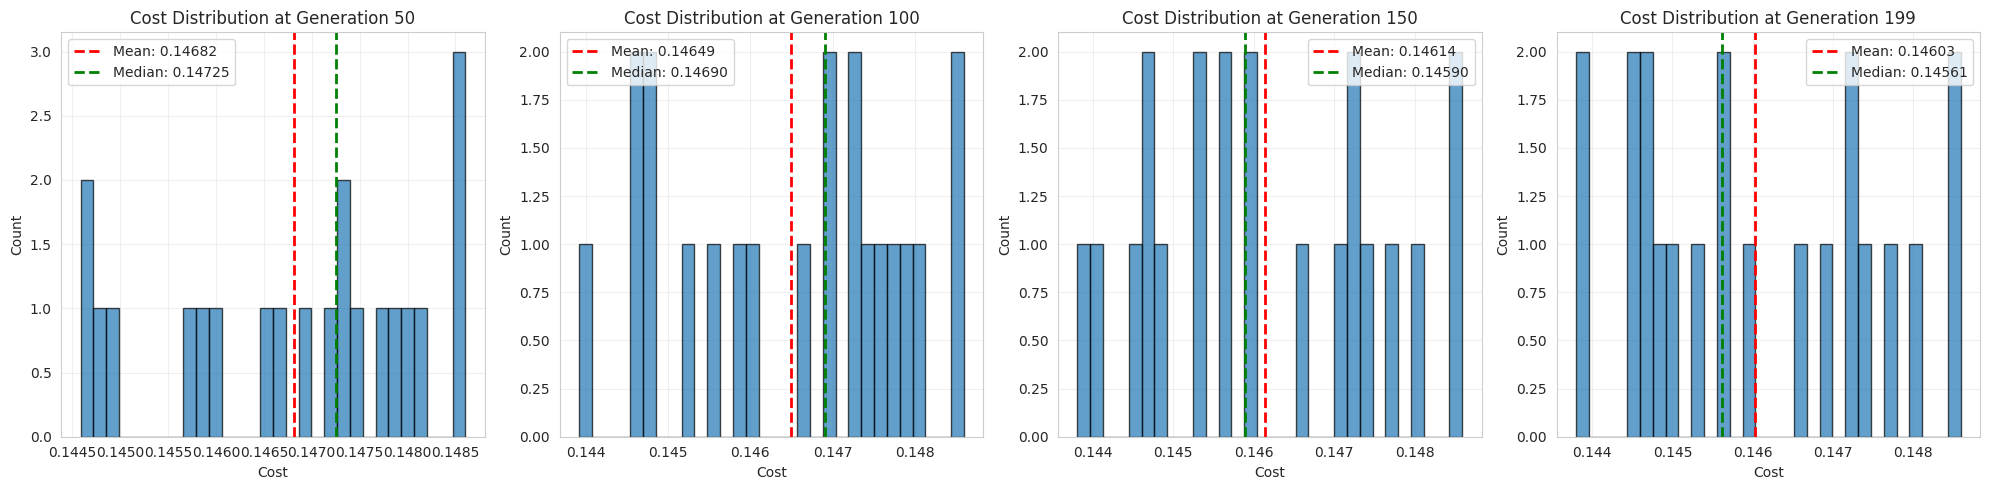

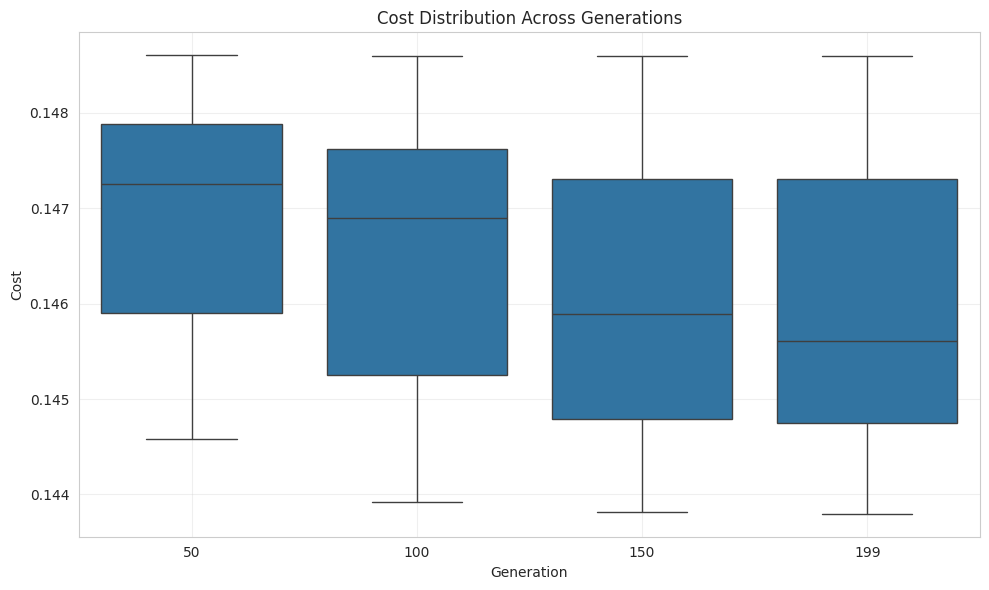

In [6]:
if len(df) > 0:
    # Get cost columns for the specified generations
    cost_cols = [f'cost_gen_{gen}' for gen in generations_to_analyze if f'cost_gen_{gen}' in df.columns]
    
    if len(cost_cols) > 0:
        fig, axes = plt.subplots(1, len(cost_cols), figsize=(5*len(cost_cols), 5))
        if len(cost_cols) == 1:
            axes = [axes]
        
        for ax, col in zip(axes, cost_cols):
            gen = int(col.split('_')[-1])
            ax.hist(df[col], bins=30, edgecolor='black', alpha=0.7)
            ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.5f}')
            ax.axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[col].median():.5f}')
            ax.set_xlabel('Cost')
            ax.set_ylabel('Count')
            ax.set_title(f'Cost Distribution at Generation {gen}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Box plot comparison
        plt.figure(figsize=(10, 6))
        df_melt = df[cost_cols].melt(var_name='Generation', value_name='Cost')
        df_melt['Generation'] = df_melt['Generation'].str.extract(r'(\d+)').astype(int)
        sns.boxplot(data=df_melt, x='Generation', y='Cost')
        plt.title('Cost Distribution Across Generations')
        plt.ylabel('Cost')
        plt.xlabel('Generation')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Hyperparameter Impact Analysis

Analyze how each hyperparameter affects performance and runtime.

In [7]:
if len(df) > 0:
    # Identify modifier columns
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 'n_generations'] and 
                     not col.startswith('cost_gen_')]
    
    print(f"Analyzing {len(modifier_cols)} hyperparameters...\n")
    
    for modifier in modifier_cols:
        # Check if numeric or categorical
        is_numeric = pd.api.types.is_numeric_dtype(df[modifier])
        is_boolean = df[modifier].dtype == bool or set(df[modifier].unique()).issubset({True, False, np.nan})
        n_unique = df[modifier].nunique()
        
        print(f"\n{'='*70}")
        print(f"{modifier}")
        print(f"{'='*70}")
        print(f"Type: {'Boolean' if is_boolean else ('Numeric' if is_numeric else 'Categorical')}")
        print(f"Unique values: {n_unique}")
        if n_unique <= 10:
            print(f"Values: {sorted(df[modifier].unique())}")
        else:
            print(f"Range: [{df[modifier].min():.4g}, {df[modifier].max():.4g}]")
        
        # Correlation and p-value with final cost
        if is_numeric and not is_boolean and n_unique > 2:
            corr = df[[modifier, 'cost_final']].corr().iloc[0, 1]
            p_val, test_name = compute_pvalue(df, modifier, 'cost_final')
            print(f"Correlation with final cost: {corr:.3f} ({format_pvalue(p_val)})")
        elif n_unique >= 2:
            p_val, test_name = compute_pvalue(df, modifier, 'cost_final')
            print(f"Association with final cost: {format_pvalue(p_val)} [{test_name}]")
        
        # Correlation and p-value with runtime
        if 'runtime' in df.columns and not df['runtime'].isna().all():
            if is_numeric and not is_boolean and n_unique > 2:
                corr_runtime = df[[modifier, 'runtime']].corr().iloc[0, 1]
                p_val_rt, test_name_rt = compute_pvalue(df, modifier, 'runtime')
                print(f"Correlation with runtime: {corr_runtime:.3f} ({format_pvalue(p_val_rt)})")
            elif n_unique >= 2:
                p_val_rt, test_name_rt = compute_pvalue(df, modifier, 'runtime')
                print(f"Association with runtime: {format_pvalue(p_val_rt)} [{test_name_rt}]")

Analyzing 16 hyperparameters...


scale_population
Type: Numeric
Unique values: 21
Range: [1.771, 9.604]
Correlation with final cost: -0.103 (p=0.657)
Correlation with runtime: 0.791 (p<0.001***)

genetic_diversity
Type: Boolean
Unique values: 2
Values: [np.False_, np.True_]
Association with final cost: p=0.024* [LinReg]
Association with runtime: p=0.773 [LinReg]

no_jiggle
Type: Boolean
Unique values: 2
Values: [np.False_, np.True_]
Association with final cost: p=0.254 [LinReg]
Association with runtime: p=0.703 [LinReg]

bfgs_for_rough
Type: Boolean
Unique values: 2
Values: [np.False_, np.True_]
Association with final cost: p=0.574 [LinReg]
Association with runtime: p=0.998 [LinReg]

scale_rough_iterations
Type: Numeric
Unique values: 21
Range: [0.1149, 0.9538]
Correlation with final cost: 0.078 (p=0.738)
Correlation with runtime: -0.067 (p=0.774)

scale_fine_iterations
Type: Numeric
Unique values: 21
Range: [0.1485, 0.9887]
Correlation with final cost: -0.067 (p=0.772)
Correlation wi

## Scatter Plots: Cost vs Hyperparameters

Visualize relationship between each hyperparameter and cost at different generations.

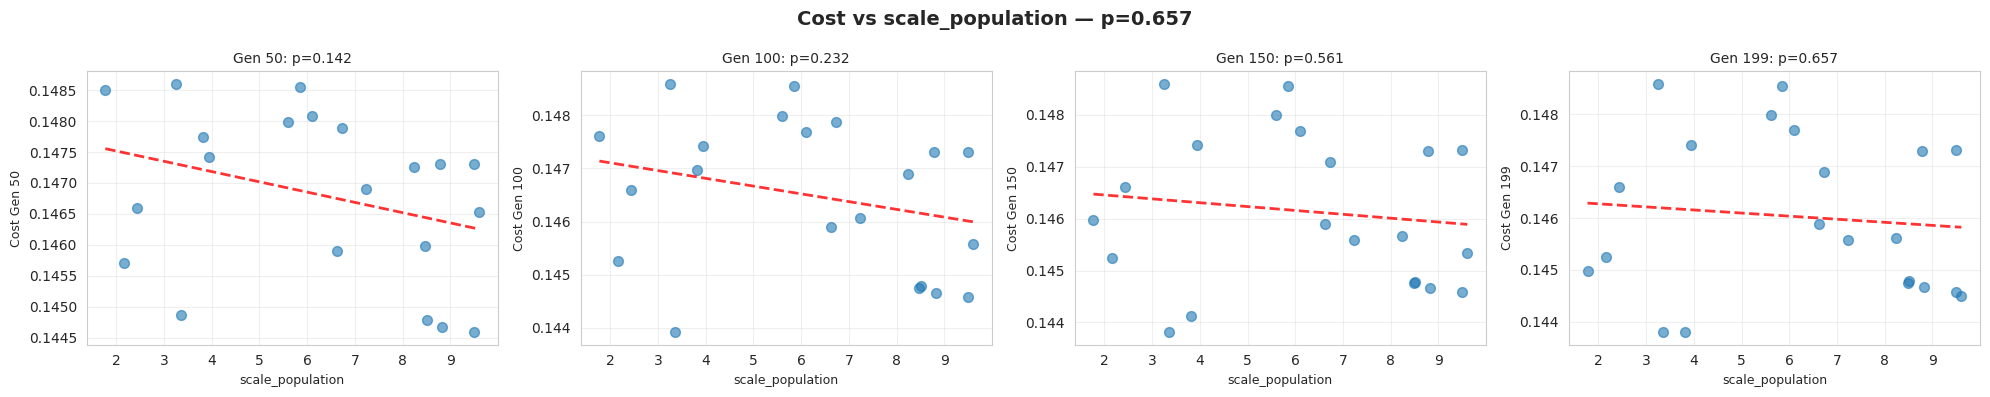

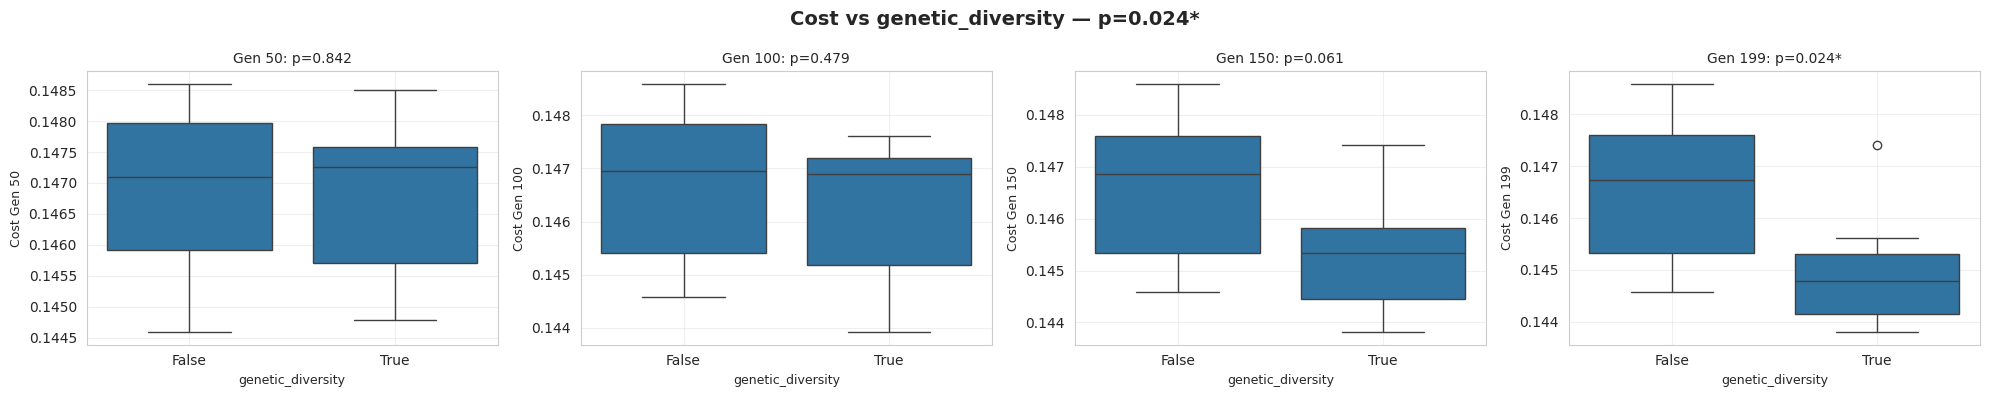

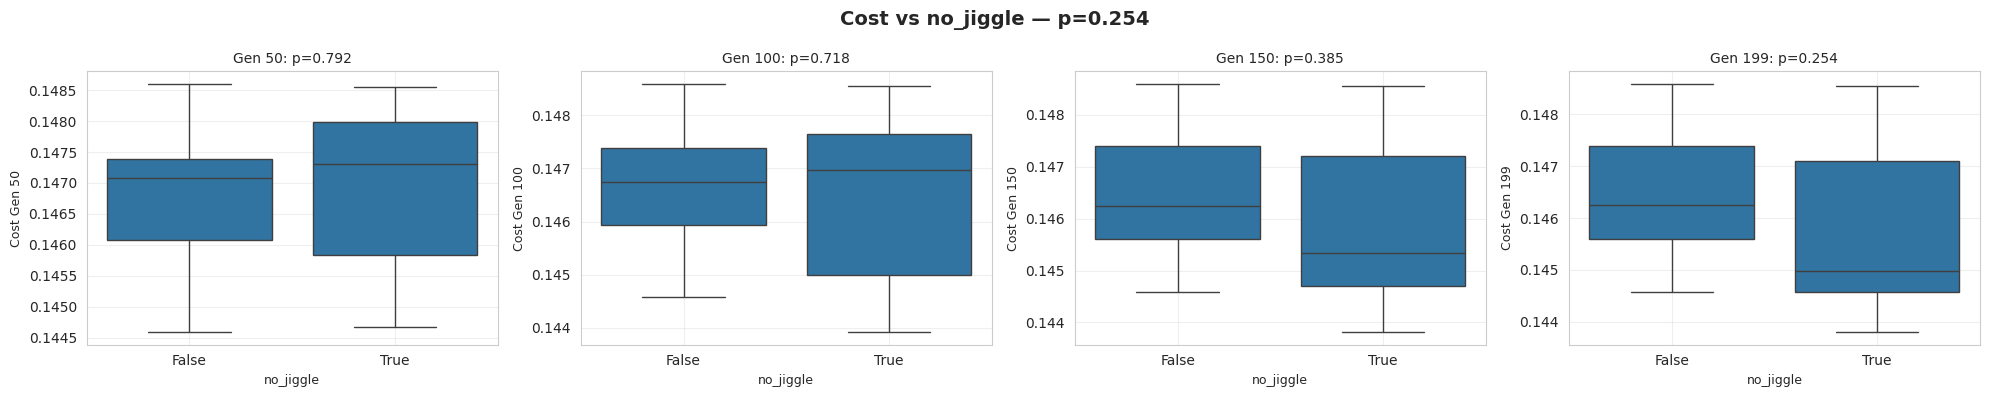

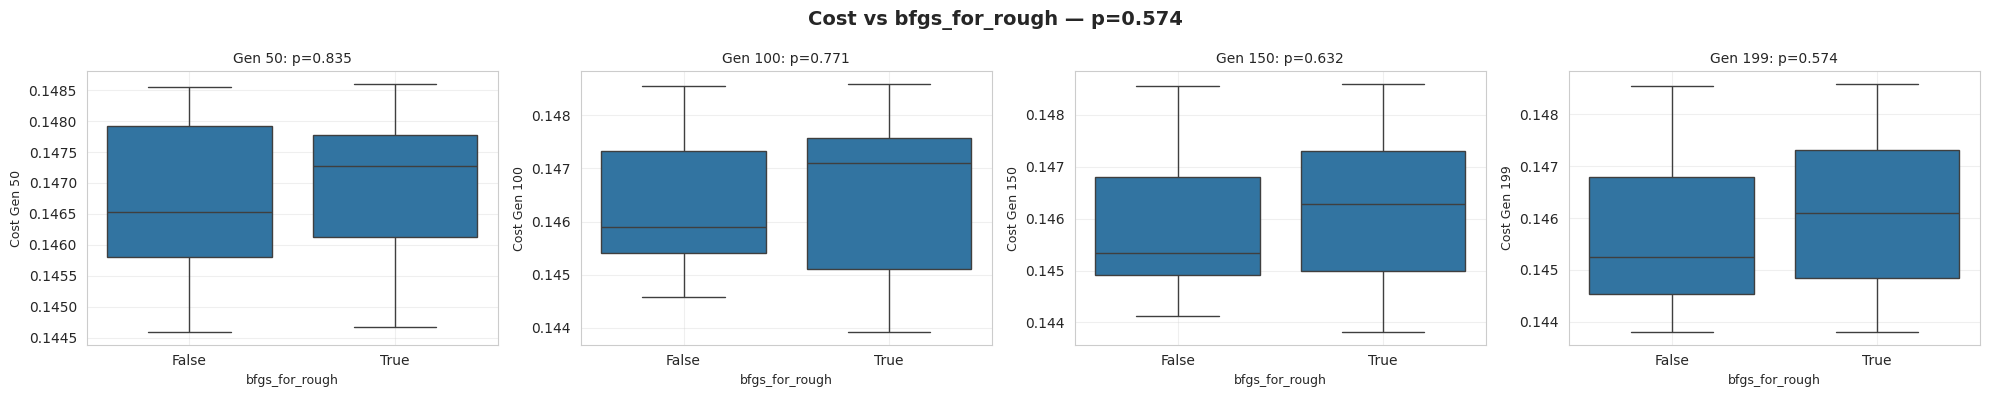

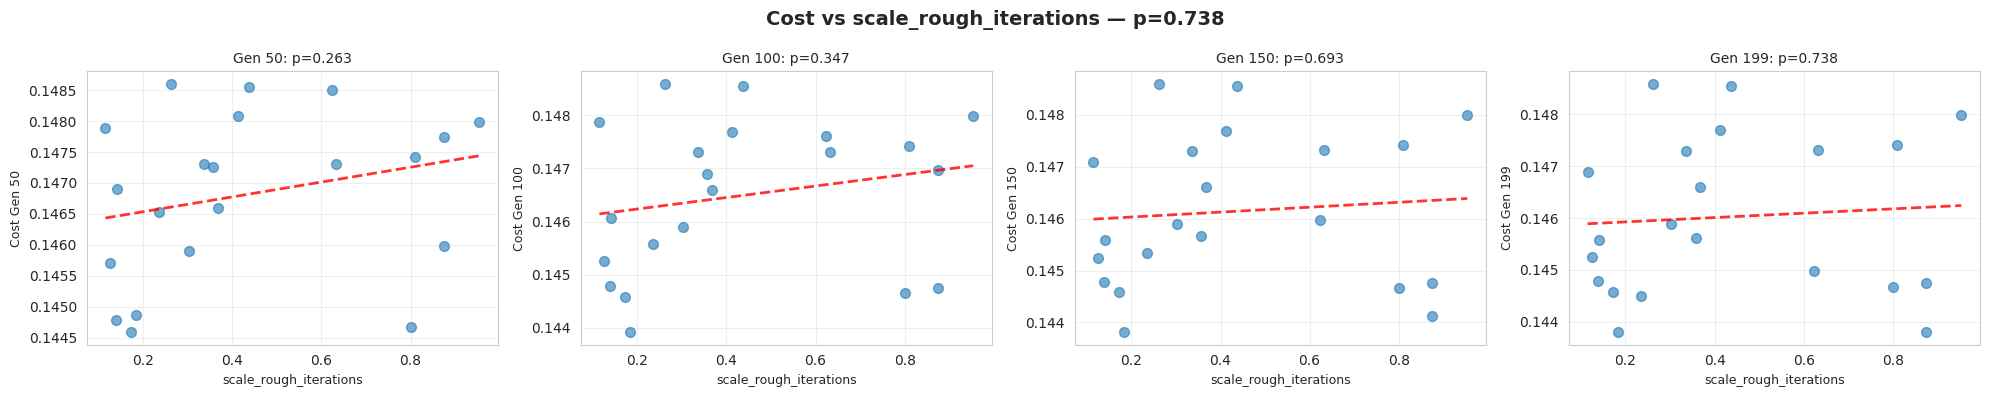

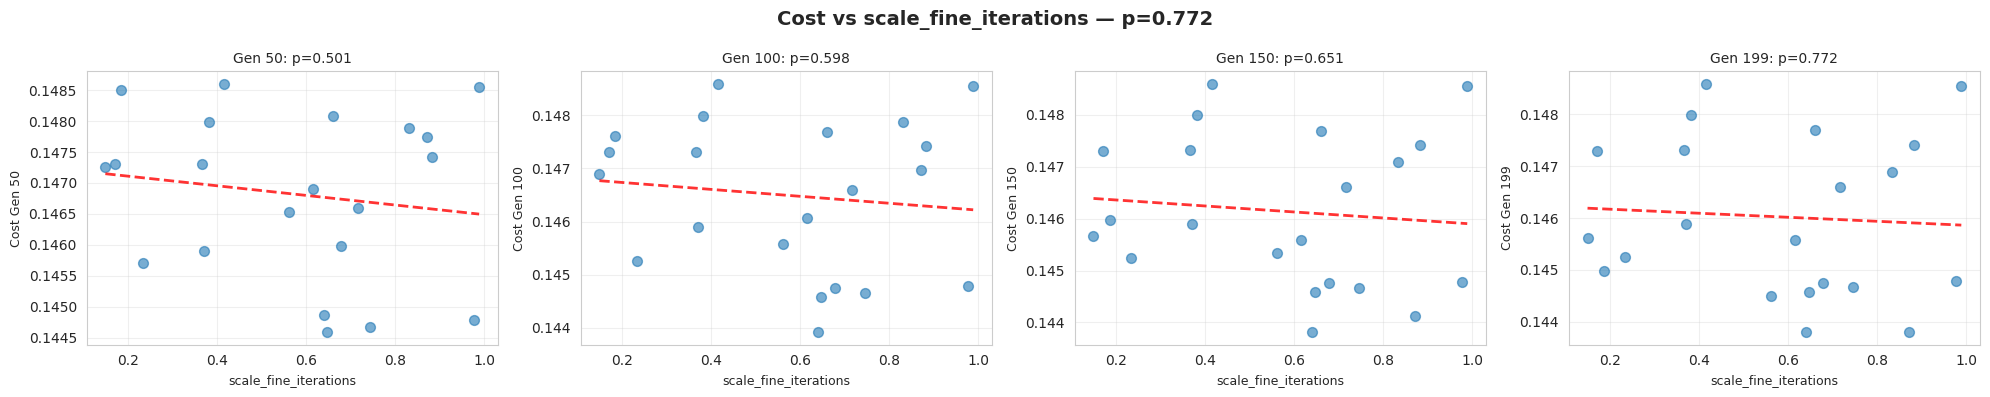

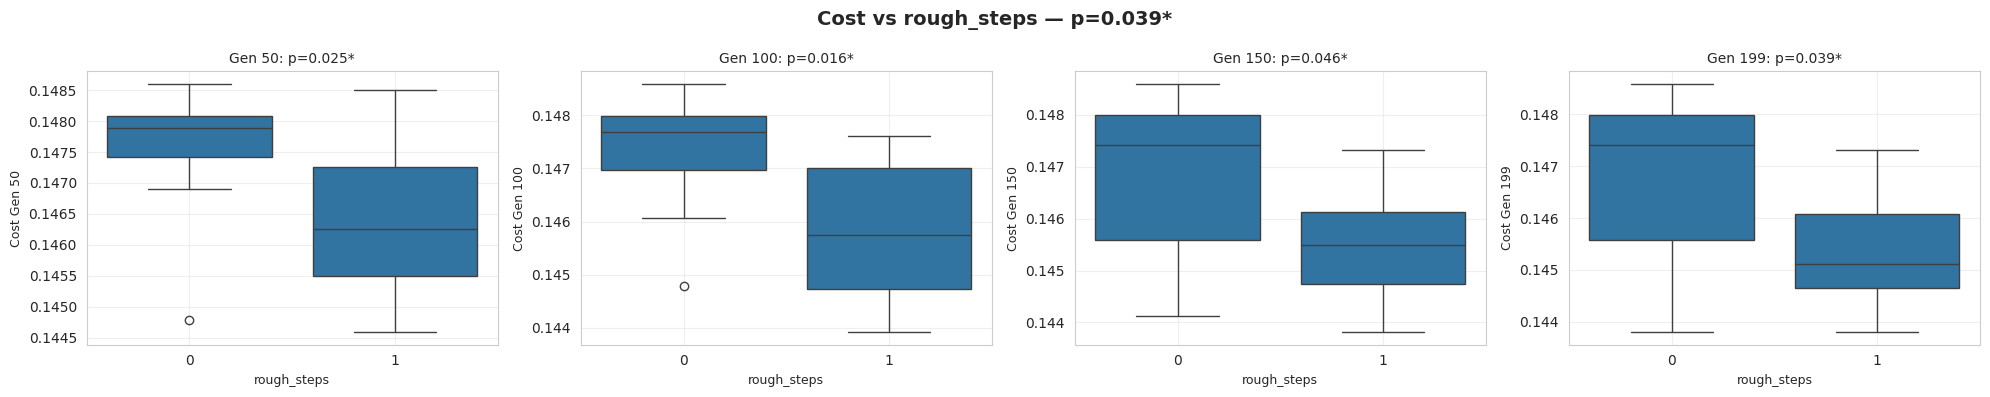

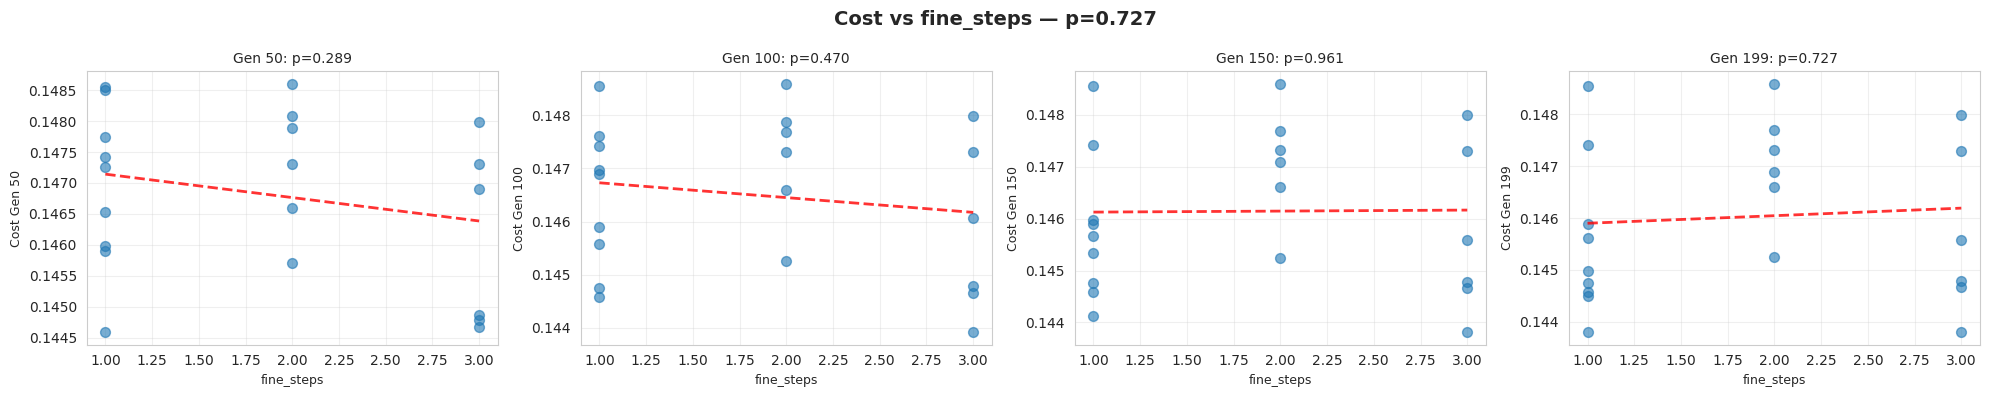

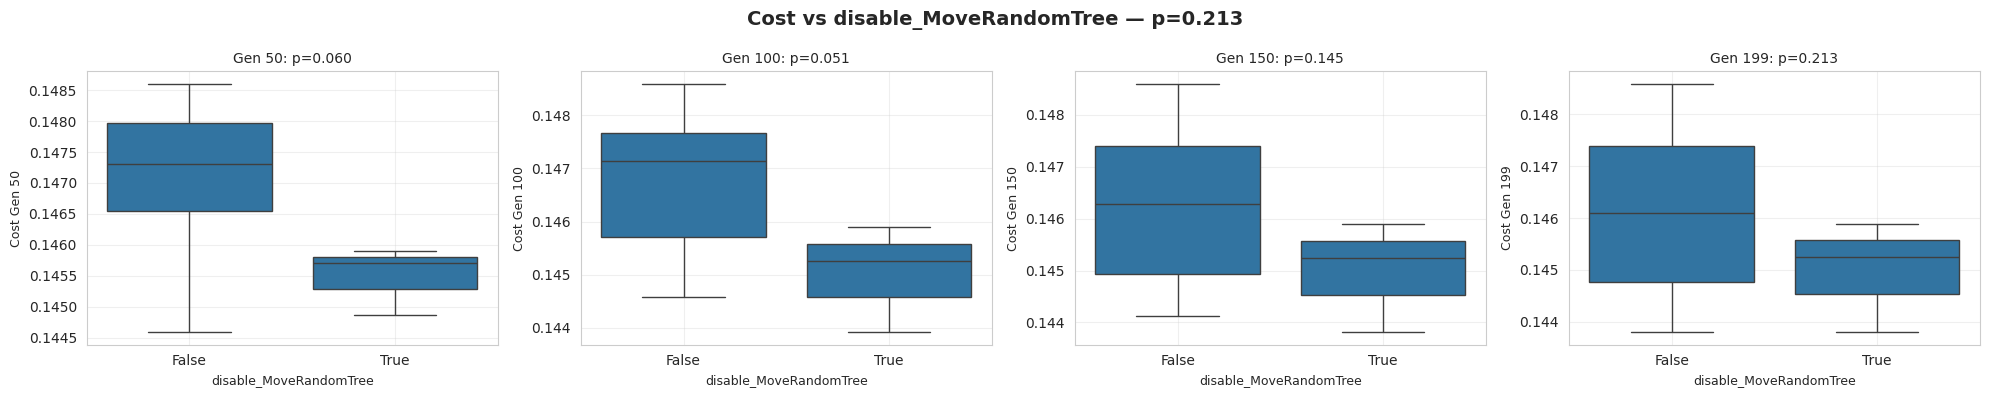

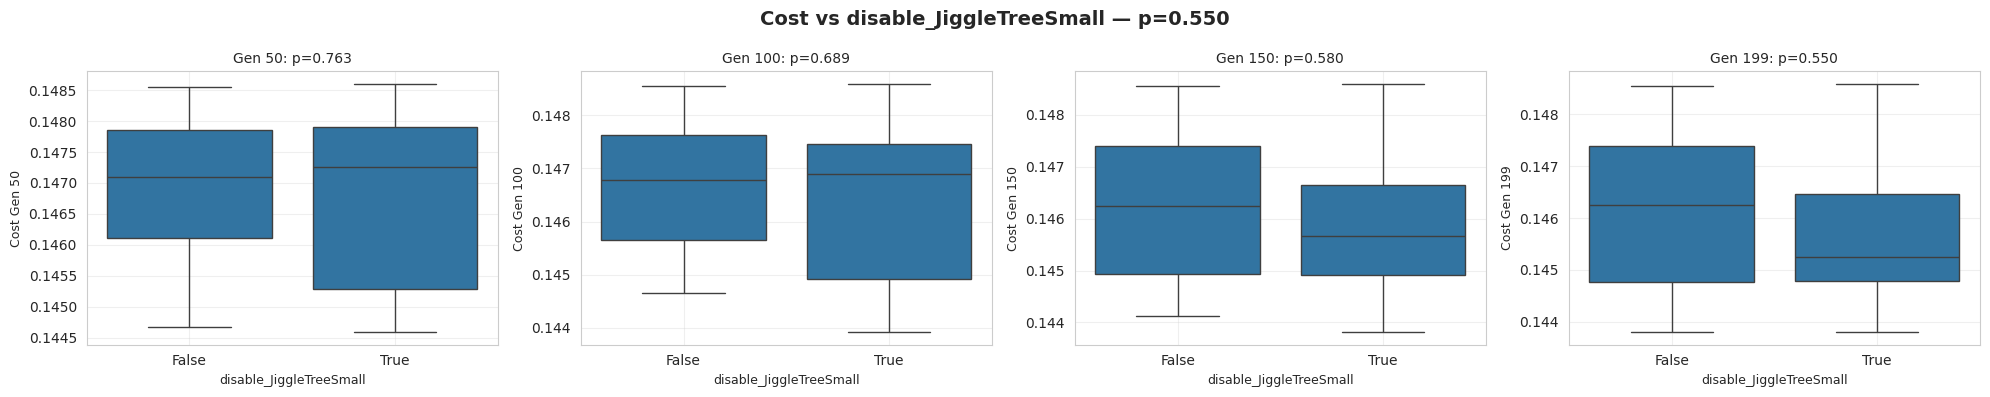

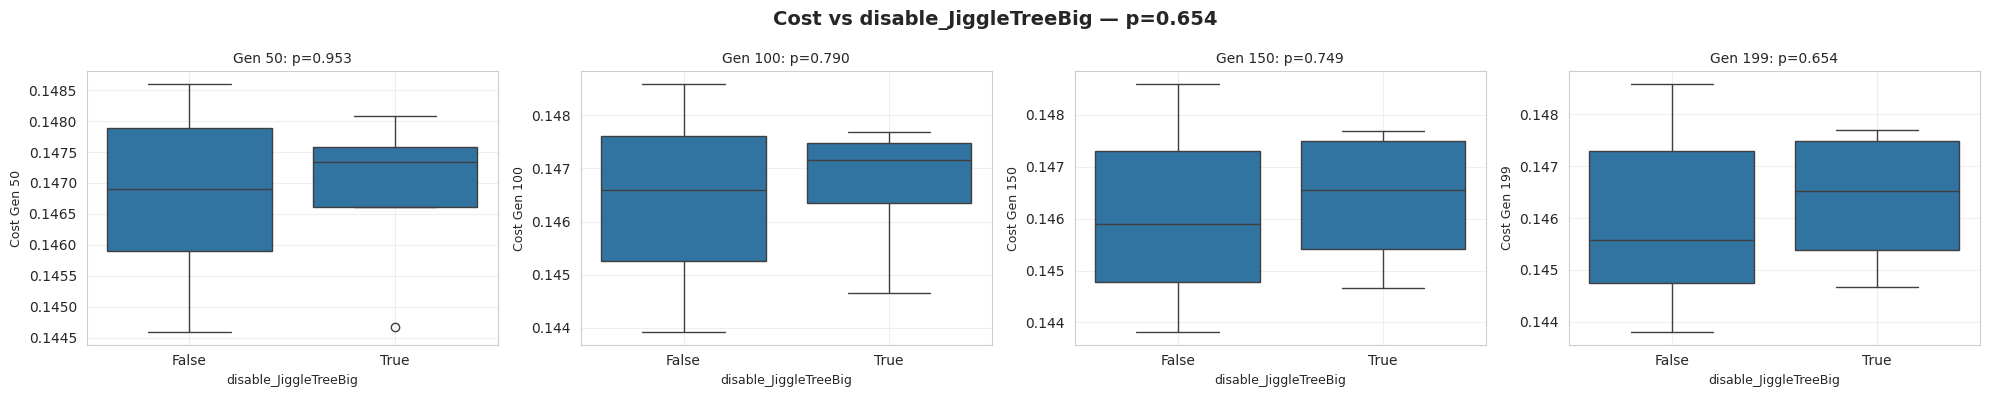

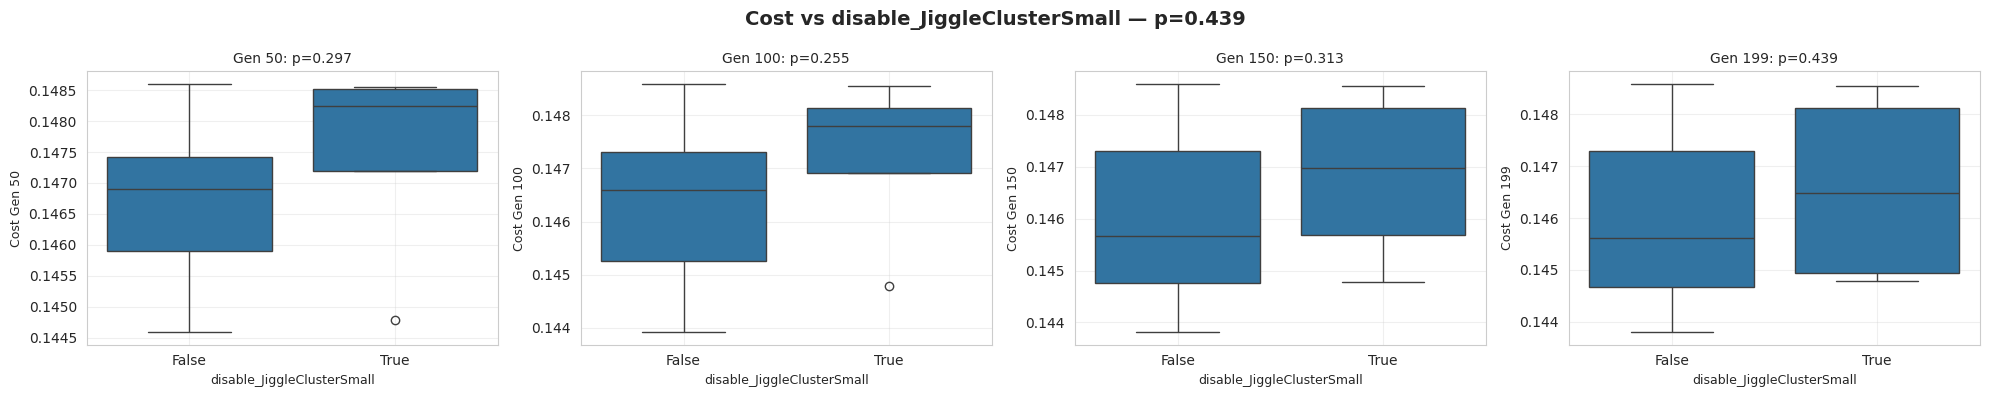

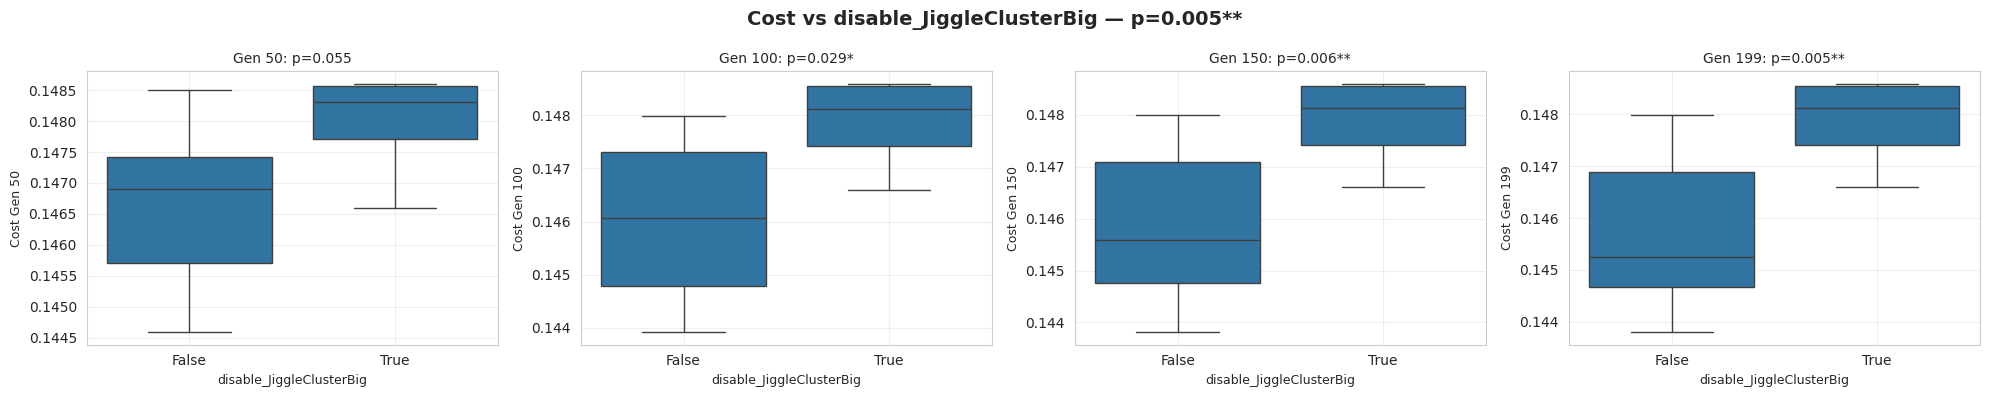

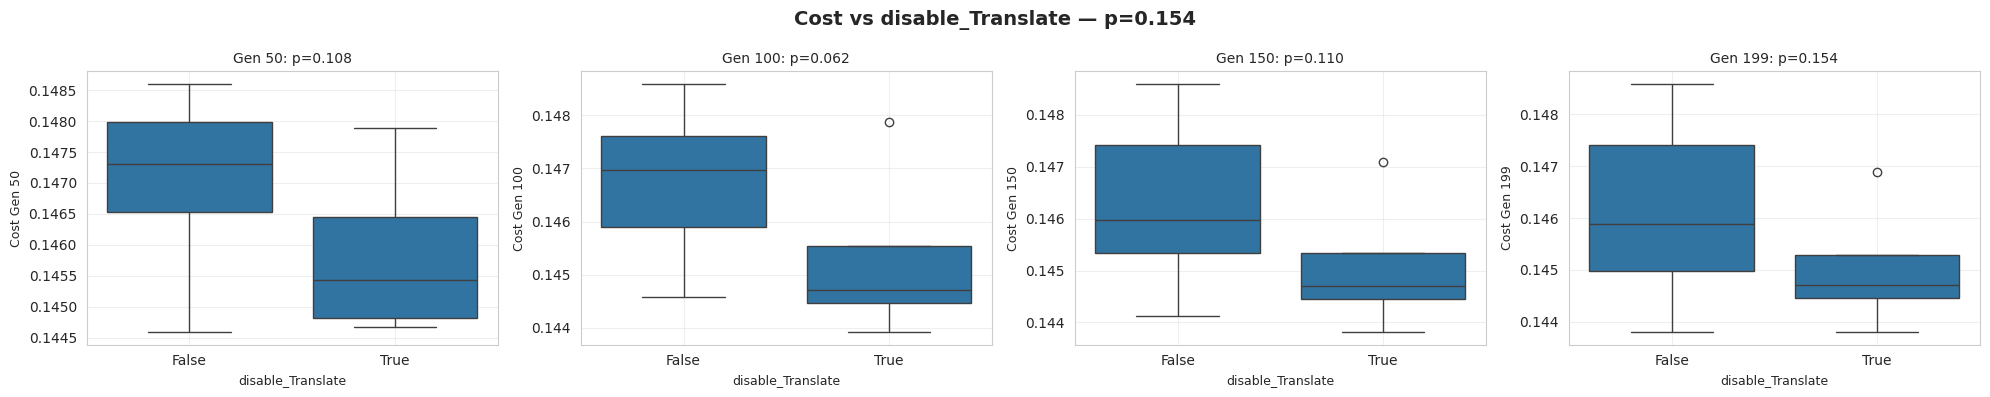

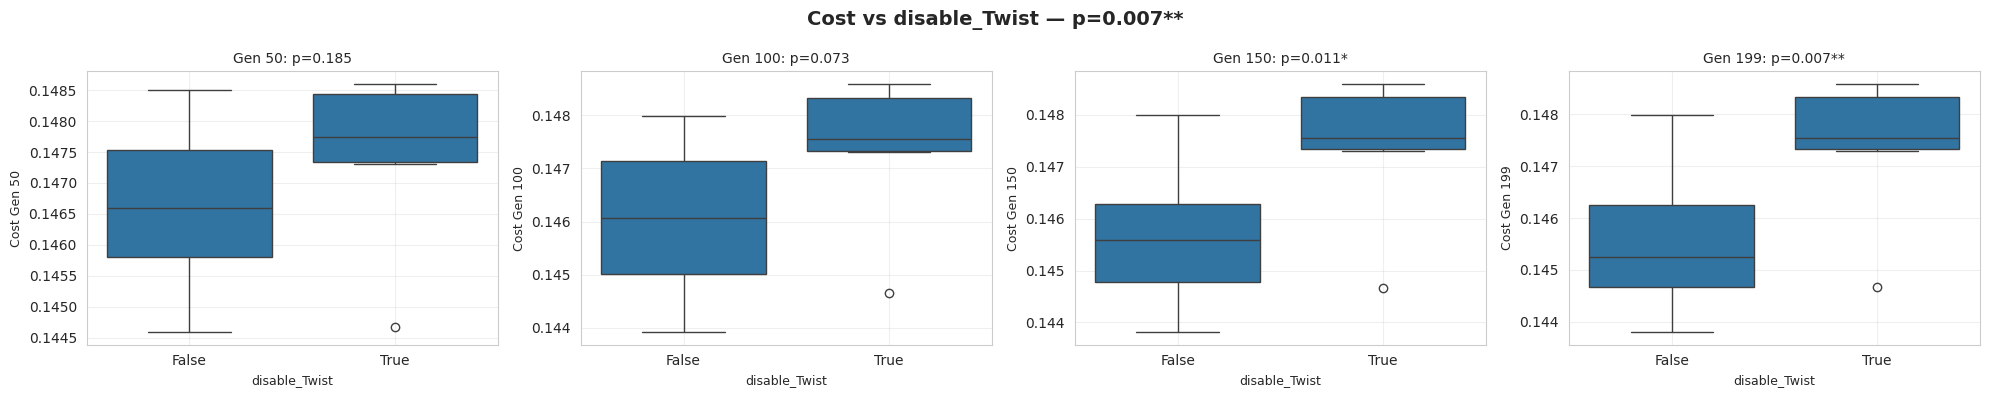

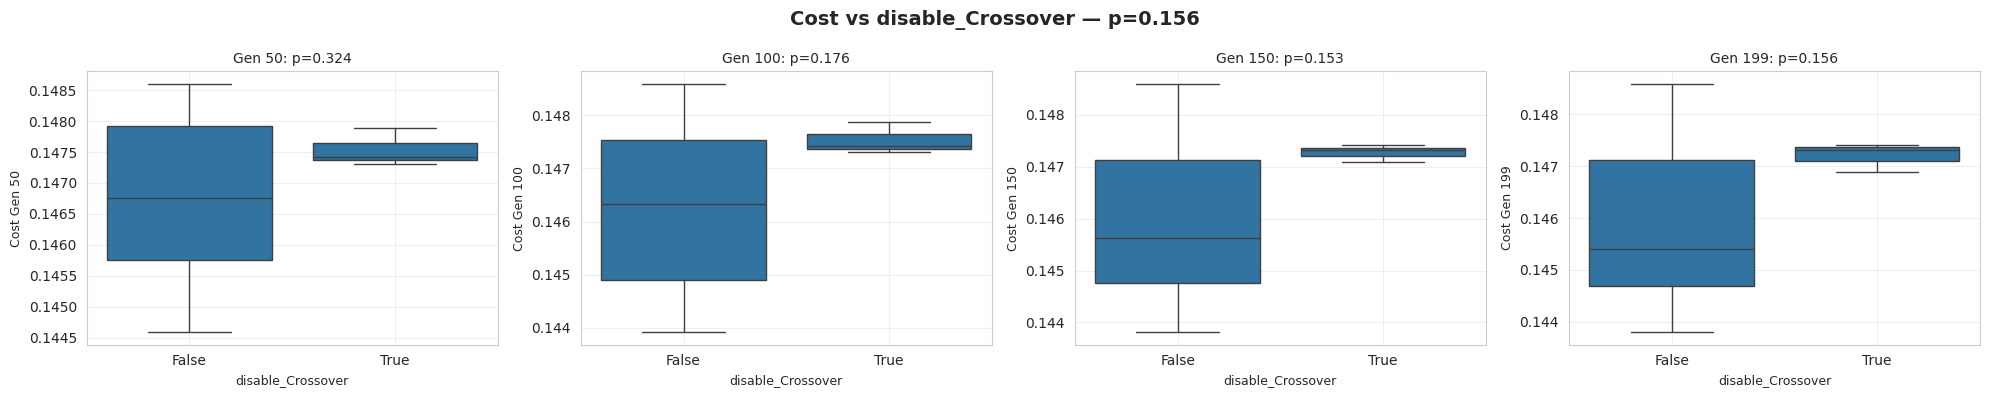

In [8]:
if len(df) > 0:
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 'n_generations'] and 
                     not col.startswith('cost_gen_')]
    
    cost_cols = [f'cost_gen_{gen}' for gen in generations_to_analyze if f'cost_gen_{gen}' in df.columns]
    
    if len(cost_cols) == 0:
        print("No cost columns found for specified generations!")
    
    # Filter out modifiers with no variation
    modifier_cols = [col for col in modifier_cols if df[col].nunique() > 1]
    
    for modifier in modifier_cols:
        # Create subplots for each generation
        n_plots = len(cost_cols)
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
        if n_plots == 1:
            axes = [axes]
        
        # Compute p-value for final cost to show in main title
        p_val_final, test_name = compute_pvalue(df, modifier, 'cost_final')
        fig.suptitle(f'Cost vs {modifier} — {format_pvalue(p_val_final)}', fontsize=14, fontweight='bold')
        
        for ax, cost_col in zip(axes, cost_cols):
            gen = int(cost_col.split('_')[-1])
            
            # Use helper function to create plot
            p_val = plot_modifier_vs_outcome(ax, df, modifier, cost_col, show_pval=True)
            
            # Update title to include generation info
            current_title = ax.get_title()
            ax.set_title(f'Gen {gen}: {current_title}', fontsize=10)
        
        plt.tight_layout()
        plt.show()

## Runtime Analysis

Analyze how each hyperparameter affects runtime.

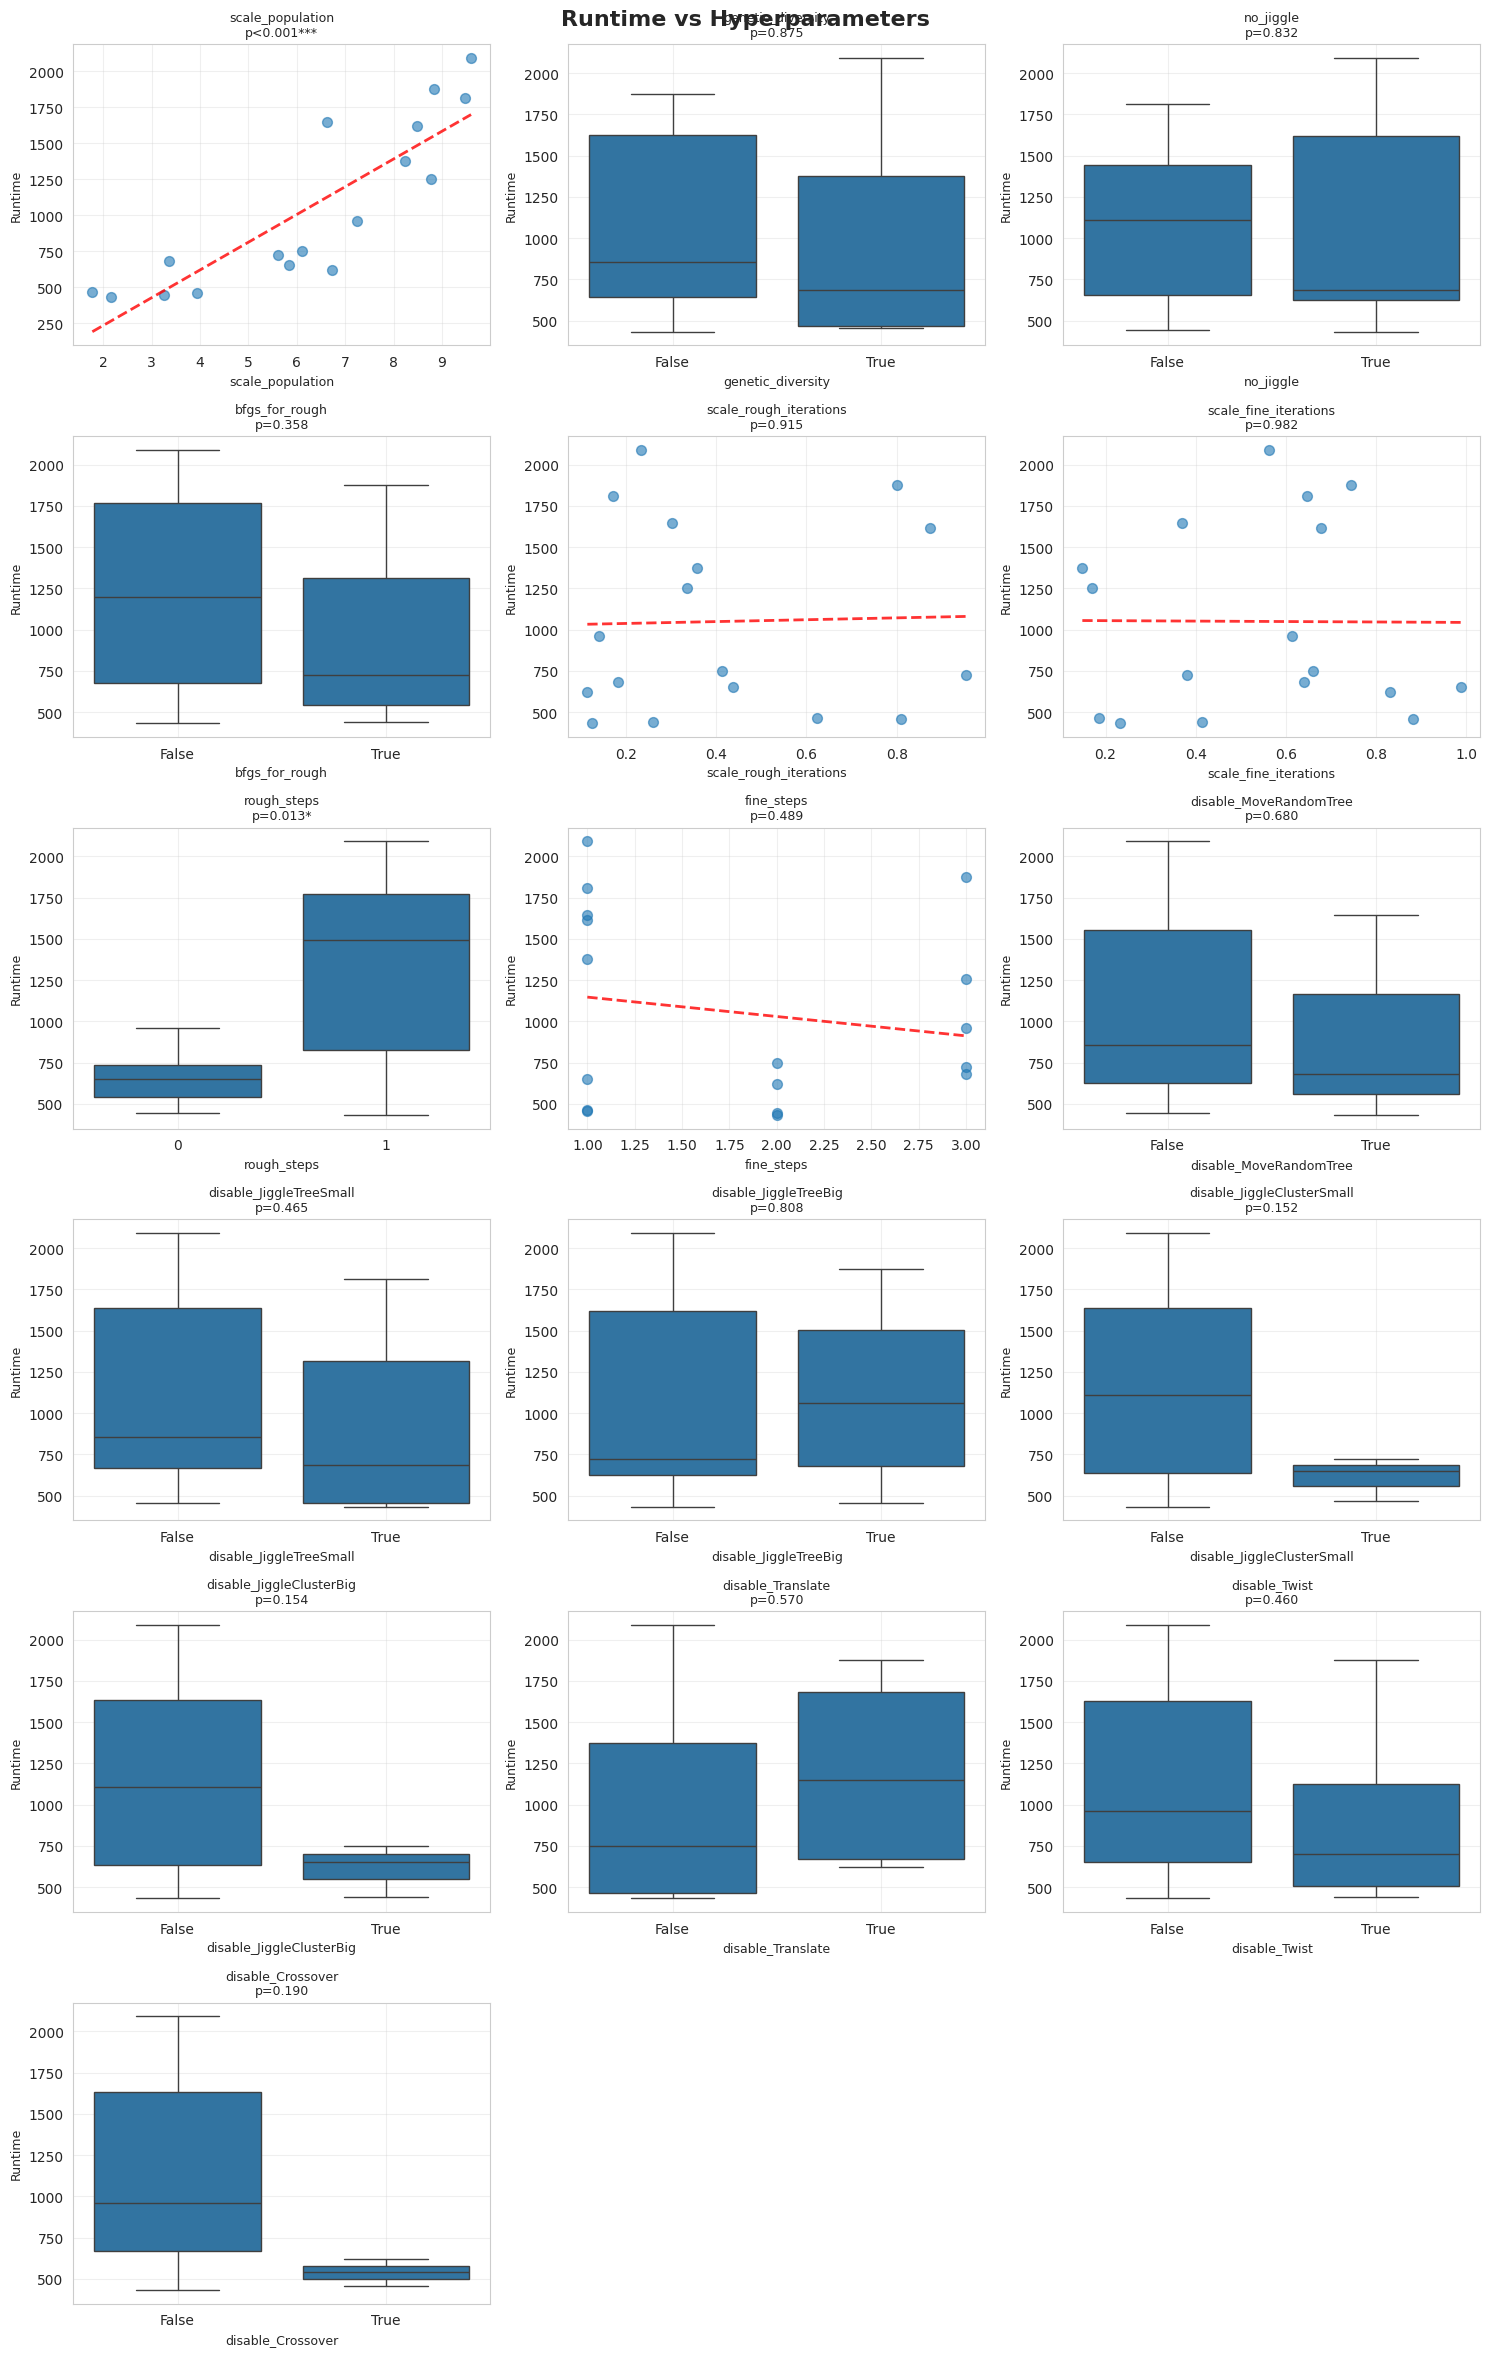

In [9]:
dfx = df[df['seed']<100]
if len(dfx) > 0 and 'runtime' in dfx.columns and not dfx['runtime'].isna().all():
    modifier_cols = [col for col in dfx.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std', 'n_generations'] and 
                     not col.startswith('cost_gen_')]
    
    # Filter out modifiers with no variation
    modifier_cols = [col for col in modifier_cols if dfx[col].nunique() > 1]
    
    if len(modifier_cols) == 0:
        print("No modifiers with variation to plot!")
    else:
        # Create grid of plots
        n_cols = min(3, len(modifier_cols))
        n_rows = (len(modifier_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1 or n_cols == 1:
            axes = axes.reshape(n_rows, n_cols)
        
        fig.suptitle('Runtime vs Hyperparameters', fontsize=16, fontweight='bold')
        
        for idx, modifier in enumerate(modifier_cols):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            # Use helper function to create plot
            p_val = plot_modifier_vs_outcome(ax, dfx, modifier, 'runtime', show_pval=True)
            
            # Update title to include modifier name
            current_title = ax.get_title()
            ax.set_title(f'{modifier}\n{current_title}', fontsize=9)
        
        # Hide empty subplots
        for idx in range(len(modifier_cols), n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("No runtime data available for analysis")

## Correlation Matrix

Show correlations between all numeric hyperparameters, runtime, and costs.

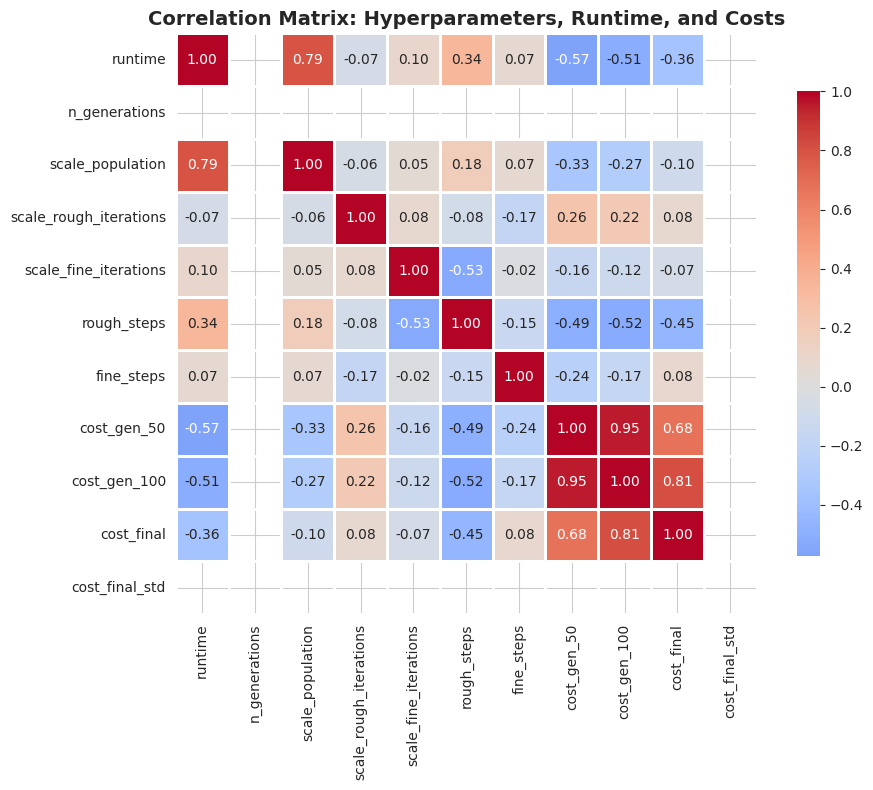


Strongest correlations with final cost:
cost_gen_100                  : +0.815
cost_gen_50                   : +0.675
rough_steps                   : -0.453
runtime                       : -0.361
scale_population              : -0.103
fine_steps                    : +0.081
scale_rough_iterations        : +0.078
scale_fine_iterations         : -0.067
n_generations                 : +nan
cost_final_std                : +nan


In [10]:
if len(df) > 0:
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove seed and filename-related columns
    numeric_cols = [col for col in numeric_cols if col not in ['seed'] and not col.startswith('cost_gen_') or col in [f'cost_gen_{gen}' for gen in generations_to_analyze[:2]]]
    
    if len(numeric_cols) > 1:
        # Compute correlation matrix
        corr_matrix = df[numeric_cols].corr()
        
        # Plot heatmap
        plt.figure(figsize=(max(10, len(numeric_cols)*0.8), max(8, len(numeric_cols)*0.6)))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Correlation Matrix: Hyperparameters, Runtime, and Costs', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Print strongest correlations with final cost
        if 'cost_final' in corr_matrix.columns:
            cost_corrs = corr_matrix['cost_final'].drop('cost_final').sort_values(key=abs, ascending=False)
            print("\nStrongest correlations with final cost:")
            print("="*50)
            for param, corr in cost_corrs.head(10).items():
                print(f"{param:30s}: {corr:+.3f}")

## Best Hyperparameter Settings

Identify the best hyperparameter combinations.

In [11]:
if len(df) > 0:
    modifier_cols = [col for col in df.columns if col not in 
                     ['seed', 'runtime', 'filename', 'cost_final', 'cost_final_std'] and 
                     not col.startswith('cost_gen_')]
    
    print("="*70)
    print("TOP 10 BEST HYPERPARAMETER SETTINGS (by final cost)")
    print("="*70)
    
    best_df = df.nsmallest(10, 'cost_final')
    
    for rank, (idx, row) in enumerate(best_df.iterrows(), 1):
        print(f"\n#{rank} - Seed {row['seed']} - Cost: {row['cost_final']:.6f}")
        print("-" * 70)
        for col in modifier_cols:
            print(f"  {col:30s}: {row[col]}")
        if 'runtime' in row and not pd.isna(row['runtime']):
            print(f"  {'Runtime':30s}: {row['runtime']:.1f}s")
    
    # Summary statistics for best vs worst
    print("\n" + "="*70)
    print("COMPARISON: Top 25% vs Bottom 25%")
    print("="*70)
    
    n_quartile = max(1, len(df) // 4)
    top_25 = df.nsmallest(n_quartile, 'cost_final')
    bottom_25 = df.nlargest(n_quartile, 'cost_final')
    
    for col in modifier_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            top_mean = top_25[col].mean()
            bottom_mean = bottom_25[col].mean()
            diff = top_mean - bottom_mean
            print(f"\n{col}:")
            print(f"  Top 25% mean:    {top_mean:.4g}")
            print(f"  Bottom 25% mean: {bottom_mean:.4g}")
            print(f"  Difference:      {diff:+.4g}")

TOP 10 BEST HYPERPARAMETER SETTINGS (by final cost)

#1 - Seed 103 - Cost: 0.143797
----------------------------------------------------------------------
  n_generations                 : 200
  scale_population              : 3.8141490945065275
  genetic_diversity             : True
  no_jiggle                     : True
  bfgs_for_rough                : False
  scale_rough_iterations        : 0.874160781034089
  scale_fine_iterations         : 0.8717882395423325
  rough_steps                   : 0
  fine_steps                    : 1
  disable_MoveRandomTree        : False
  disable_JiggleTreeSmall       : False
  disable_JiggleTreeBig         : False
  disable_JiggleClusterSmall    : False
  disable_JiggleClusterBig      : False
  disable_Translate             : False
  disable_Twist                 : False
  disable_Crossover             : False
  Runtime                       : 881.5s

#2 - Seed 2 - Cost: 0.143808
--------------------------------------------------------------------

## Export Results

Save analysis results to CSV for further processing.

In [12]:
if len(df) > 0:
    output_file = f'../../results/many_ga/analysis_{runner_name}.csv'
    df.to_csv(output_file, index=False)
    print(f"Results saved to: {output_file}")
    print(f"Shape: {df.shape}")

Results saved to: ../../results/many_ga/analysis_Baseline.csv
Shape: (21, 30)
